# PDCADx: Leak-Proof Two-Phase Pipeline

This notebook implements a **leak-proof** training and evaluation workflow:

- **Phase A (Tuning):** Train on **train only**, evaluate on **val**, select best hyperparameters (XGBoost) and tune decision **threshold** on validation (max accuracy by default).
- **Phase B (Final):** Refit on **train+val** with the selected hyperparameters (no threshold here), then predict on **test** and save a submission file `label_predict.csv` in the MICCAI challenge format (`patient_id,prediction`).

> This structure avoids data leakage and ensures validation metrics are trustworthy, while still using all labeled data for the final model.

In [3]:
# =====================
# CONFIG & DEPENDENCIES
# =====================
import numpy as np, pandas as pd, joblib
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt

# ----- Paths (adjust OUT_DIR if needed)
OUT_DIR = Path("./out")  # change if your outputs live elsewhere
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Feature CSVs written earlier in your pipeline
TRAIN_FEATURES_CSV = OUT_DIR / "features_train.csv"
VAL_FEATURES_CSV   = OUT_DIR / "features_val.csv"
TEST_FEATURES_CSV  = OUT_DIR / "features_test.csv"

# Optional: where ResNet test predictions live (only needed if test lacks 'resnet_prob')
RESNET_TEST_CSV = Path(r"C:\Users\rubia\Downloads\cnn_preds\resnet_test.csv")

# Basic existence checks
assert TRAIN_FEATURES_CSV.exists(), f"Missing: {TRAIN_FEATURES_CSV}"
assert VAL_FEATURES_CSV.exists(),   f"Missing: {VAL_FEATURES_CSV}"
# TEST_FEATURES_CSV may not exist yet in some setups; that's fine for Phase A.

## Phase A — Tuning (Train → Val only)

- Load **train** and **val** features (must contain `label`).
- Use **RandomizedSearchCV** to tune XGBoost hyperparameters (on **train** only).
- Evaluate tuned model on **held-out val**.
- **Tune threshold** on val by maximizing accuracy.
- Save **tuning artifacts** (`best_pipe`, `feat_cols`, `best_thresh`) for Phase B.

Train shape: (200, 154) | Val shape: (100, 154) | #Features: 154
Best params: {'xgb__subsample': 0.9, 'xgb__reg_lambda': 1.0, 'xgb__reg_alpha': 0.5, 'xgb__n_estimators': 600, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.05, 'xgb__colsample_bytree': 0.7}
Best CV AUC (train CV): 0.865
Held-out VAL AUC: 0.878
Best threshold on VAL: 0.650 | VAL Accuracy: 0.840
VAL Confusion Matrix:
 [[42  8]
 [ 8 42]]
VAL Sensitivity: 0.840 | Specificity: 0.840


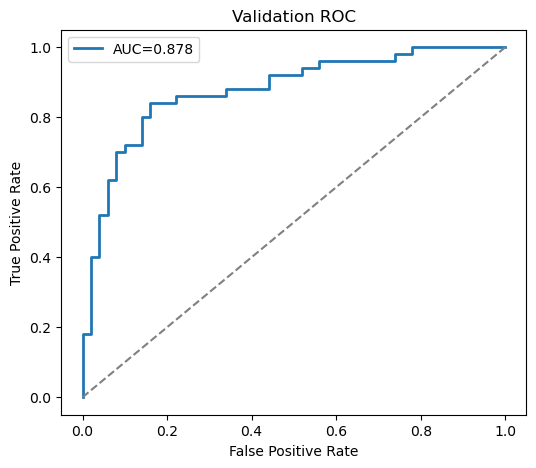

Saved tuning artifacts → out\tuning_artifacts.pkl


In [6]:
# =========================
# PHASE A: TUNING (NO LEAK)
# =========================

# ---- Load TRAIN & VAL
train_df = pd.read_csv(TRAIN_FEATURES_CSV)
val_df   = pd.read_csv(VAL_FEATURES_CSV)

for df in (train_df, val_df):
    if "subject_id" in df.columns:
        df["subject_id"] = df["subject_id"].astype(str).str.strip()

assert "label" in train_df.columns, "Train features must include 'label'."
assert "label" in val_df.columns,   "Val features must include 'label'."

# ---- Build matrices using common feature columns only
META = ["subject_id", "label"]
feat_cols_train = [c for c in train_df.columns if c not in META]
feat_cols_val   = [c for c in val_df.columns   if c not in META]

common_feats = sorted(list(set(feat_cols_train).intersection(feat_cols_val)))
assert len(common_feats) > 0, "No overlapping feature columns between train and val."

X_tr = train_df[common_feats].apply(pd.to_numeric, errors="coerce").values
y_tr = train_df["label"].astype(int).values

X_val = val_df[common_feats].apply(pd.to_numeric, errors="coerce").values
y_val = val_df["label"].astype(int).values

print("Train shape:", X_tr.shape, "| Val shape:", X_val.shape, "| #Features:", len(common_feats))

# ---- Define pipeline & parameter search
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler(with_mean=False)),
    ("xgb", xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    ))
])

param_dist = {
    "xgb__n_estimators":     [200, 400, 600, 800],
    "xgb__max_depth":        [3, 4, 6, 8],
    "xgb__learning_rate":    [0.01, 0.03, 0.05, 0.1],
    "xgb__subsample":        [0.7, 0.9, 1.0],
    "xgb__colsample_bytree": [0.7, 0.9, 1.0],
    "xgb__reg_lambda":       [0.1, 0.5, 1.0, 2.0],
    "xgb__reg_alpha":        [0.0, 0.1, 0.5, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search.fit(X_tr, y_tr)
best_pipe = search.best_estimator_
print("Best params:", search.best_params_)
print("Best CV AUC (train CV):", round(search.best_score_, 3))

# ---- Evaluate tuned model on held-out VAL
val_proba = best_pipe.predict_proba(X_val)[:, 1]
val_auc   = roc_auc_score(y_val, val_proba)
print("Held-out VAL AUC:", round(val_auc, 3))

# ---- Tune threshold on VAL by maximizing accuracy
thresholds = np.linspace(0, 1, 1001)
accs = [accuracy_score(y_val, (val_proba >= t).astype(int)) for t in thresholds]
best_idx = int(np.argmax(accs))
best_t = float(thresholds[best_idx])
best_acc = float(accs[best_idx])
print(f"Best threshold on VAL: {best_t:.3f} | VAL Accuracy: {best_acc:.3f}")

# ---- Diagnostics: Confusion Matrix + ROC
y_val_pred = (val_proba >= best_t).astype(int)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
sens = tp / (tp + fn) if (tp + fn) else 0.0
spec = tn / (tn + fp) if (tn + fp) else 0.0
print("VAL Confusion Matrix:\n", np.array([[tn, fp],[fn, tp]]))
print(f"VAL Sensitivity: {sens:.3f} | Specificity: {spec:.3f}")

fpr, tpr, _ = roc_curve(y_val, val_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC={auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Validation ROC")
plt.legend(); plt.show()

# ---- Save tuning artifacts
tune_bundle = {
    "best_pipe": best_pipe,    # fitted on TRAIN only
    "feat_cols": common_feats, # exact feature order
    "best_thresh": best_t
}
joblib.dump(tune_bundle, OUT_DIR / "tuning_artifacts.pkl")
print("Saved tuning artifacts →", OUT_DIR / "tuning_artifacts.pkl")

## Phase B — Final train+val fit and test submission

- Rebuild the tuned pipeline with **best hyperparameters** and **refit on train+val**.
- Align test features to Phase A feature list, predict probabilities, apply **Phase A threshold**, and write `label_predict.csv`.

In [11]:
# ===========================================
# PHASE B: FINAL TRAIN+VAL FIT + TEST OUTPUT
# ===========================================

tuned = joblib.load(OUT_DIR / "tuning_artifacts.pkl")
best_tuned_pipe = tuned["best_pipe"]
feat_cols       = tuned["feat_cols"]
best_t          = tuned["best_thresh"]

# ---- Load TRAIN+VAL
train_df = pd.read_csv(TRAIN_FEATURES_CSV)
val_df   = pd.read_csv(VAL_FEATURES_CSV)

for df in (train_df, val_df):
    if "subject_id" in df.columns:
        df["subject_id"] = df["subject_id"].astype(str).str.strip()

assert "label" in train_df.columns and "label" in val_df.columns, "Train/Val features must include label."

trainval_df = pd.concat([train_df, val_df], ignore_index=True)

# ---- Build matrices using the Phase-A feature list
X_tv = trainval_df[feat_cols].apply(pd.to_numeric, errors="coerce").values
y_tv = trainval_df["label"].astype(int).values

# ---- Rebuild final model with best XGB params, refit on TRAIN+VAL
# ---- Rebuild final model with best XGB params, refit on TRAIN+VAL
best_params = best_tuned_pipe.get_params()
xgb_params = {k.replace("xgb__", ""): v for k, v in best_params.items() if k.startswith("xgb__")}

final_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler(with_mean=False)),
    ("xgb", xgb.XGBClassifier(**xgb_params))
])

final_pipe.fit(X_tv, y_tv)

# ---- Save the final model bundle
joblib.dump({"model": final_pipe, "features": feat_cols, "threshold": best_t},
            OUT_DIR / "xgb_trainval_final.pkl")
print("Saved final model →", OUT_DIR / "xgb_trainval_final.pkl")

# ---- TEST prediction (if test features exist)
if TEST_FEATURES_CSV.exists():
    test_df = pd.read_csv(TEST_FEATURES_CSV)
    if "subject_id" not in test_df.columns:
        raise ValueError("features_test.csv must include 'subject_id'.")
    test_df["subject_id"] = test_df["subject_id"].astype(str).str.strip()

    # If resnet_prob missing on test and you have a csv, merge it
    if "resnet_prob" not in test_df.columns and RESNET_TEST_CSV.exists():
        rpred = pd.read_csv(RESNET_TEST_CSV)
        rpred["subject_id"] = rpred["subject_id"].astype(str).str.strip()
        if "resnet_prob" not in rpred.columns:
            raise ValueError(f"{RESNET_TEST_CSV} must include 'resnet_prob'.")
        test_df = test_df.merge(rpred[["subject_id","resnet_prob"]], on="subject_id", how="left")
        print("[test] merged resnet_prob from resnet_test.csv")

    # Align to Phase-A feature list
    for c in feat_cols:
        if c not in test_df.columns:
            test_df[c] = np.nan
    extra = [c for c in test_df.columns if c not in feat_cols + ["subject_id"]]
    if extra:
        test_df.drop(columns=extra, inplace=True)

    X_te = test_df[feat_cols].apply(pd.to_numeric, errors="coerce").values
    te_proba = final_pipe.predict_proba(X_te)[:, 1]
    te_pred  = (te_proba >= best_t).astype(int)

    sub = pd.DataFrame({
        "patient_id": test_df["subject_id"],
        "prediction": te_pred
    }).sort_values("patient_id").reset_index(drop=True)

    save_path = OUT_DIR / "label_predict.csv"
    sub.to_csv(save_path, index=False)
    print(f"Saved submission CSV → {save_path}")
    display(sub.head(10))
    print("Total rows:", len(sub))
else:
    print("No test features found; skipping submission generation.")

Saved final model → out\xgb_trainval_final.pkl
[test] merged resnet_prob from resnet_test.csv
Saved submission CSV → out\label_predict.csv


C:\Users\rubia\AppData\Local\Temp\ipykernel_21156\2044140563.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[c] = np.nan
C:\Users\rubia\AppData\Local\Temp\ipykernel_21156\2044140563.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[c] = np.nan
C:\Users\rubia\AppData\Local\Temp\ipykernel_21156\2044140563.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

,patient_id,prediction
0,RJPD_003,0
1,RJPD_007,0
2,RJPD_009,0
3,RJPD_014,0
4,RJPD_015,0
5,RJPD_020,1
6,RJPD_021,1
7,RJPD_025,0
8,RJPD_026,1
9,RJPD_030,1


Total rows: 200


In [17]:
# --- Cell 1: load data + detect NM/QSM columns and label (robust) ---
import re, numpy as np, pandas as pd

# Set your file path here
DATA_CSV = r"C:\Users\rubia\Downloads\out\features_train.csv"  # or r"/mnt/data/features_train.csv"

# OPTIONAL: if you know the exact label column name, set it here (e.g., "diagnosis" / "Group")
# LABEL_COL_OVERRIDE = "diagnosis"

df_regions = pd.read_csv(DATA_CSV)
print("Loaded:", DATA_CSV, "shape=", df_regions.shape)

# ------------- Detect label column -------------
def coerce_to_binary(s):
    """Try to coerce a Series to {0,1} with sensible mappings."""
    if np.issubdtype(s.dtype, np.number):
        # numeric -> map min->0, max->1 if exactly 2 unique (excluding NaN)
        vals = pd.unique(s.dropna())
        if len(vals) == 2:
            lo, hi = np.sort(vals)[:2]
            return s.map(lambda v: 0 if v==lo else (1 if v==hi else np.nan)).astype("float")
        return pd.to_numeric(s, errors="coerce")
    # string/categorical
    m = {"hc":0,"control":0,"c":0,"healthy":0,"0":0,
         "pd":1,"patient":1,"p":1,"case":1,"1":1}
    return s.astype(str).str.strip().str.lower().map(m)

label_col = None
y = None

# 1) Manual override
if "LABEL_COL_OVERRIDE" in globals() and LABEL_COL_OVERRIDE in df_regions.columns:
    label_col = LABEL_COL_OVERRIDE
    y = coerce_to_binary(df_regions[label_col])

# 2) Common names
if y is None or y.isna().all():
    for cand in ["label","PD","pd","target","y","diagnosis","dx","group","Group","class","status","is_pd","pd_label","condition","outcome"]:
        if cand in df_regions.columns:
            yc = coerce_to_binary(df_regions[cand])
            if yc.notna().sum() >= len(df_regions)*0.9:  # mostly valid
                label_col = cand
                y = yc
                break

# 3) Any binary-looking column (skip obvious region feature columns)
if y is None or y.isna().all():
    region_like = re.compile(r"(?i)\b(?:nm|qsm)\s*[_\-\s]?\s*\d{1,2}\b")
    for col in df_regions.columns:
        if region_like.search(str(col)):  # skip feature columns
            continue
        vals = pd.unique(df_regions[col].dropna())
        if len(vals) == 2:
            yc = coerce_to_binary(df_regions[col])
            if yc.notna().sum() >= len(df_regions)*0.9:
                label_col = col
                y = yc
                break

if y is not None:
    y = y.fillna(0).astype(int)
    df_regions["__PD__"] = y
    print(f"Label detected → using column: {label_col} (stored as __PD__)")
else:
    print("No label column detected. Visuals will be generated without PD split.")

# ------------- Detect NM/QSM region columns (1..16) -------------
def find_region_columns(df, tag="NM"):
    out = {}
    pat = re.compile(rf"(?i)\b{tag}\s*[_\-\s]?\s*(\d{{1,2}})\b")
    for col in df.columns:
        m = pat.search(str(col))
        if m:
            idx = int(m.group(1))
            if 1 <= idx <= 16 and idx not in out:
                out[idx] = col
    if not out:
        # loose fallback: any column containing tag + a number
        for col in df.columns:
            if tag.lower() in str(col).lower():
                m2 = re.search(r"(\d{1,2})", str(col))
                if m2:
                    idx = int(m2.group(1))
                    if 1 <= idx <= 16 and idx not in out:
                        out[idx] = col
    missing = [i for i in range(1,17) if i not in out]
    if missing:
        print(f"Warning: missing {tag} columns for indices: {missing}")
    return [out[i] for i in range(1,17) if i in out]

NM_cols  = find_region_columns(df_regions, "NM")
QSM_cols = find_region_columns(df_regions, "QSM")

print(f"Detected NM columns ({len(NM_cols)}):", NM_cols[:6], "..." if len(NM_cols)>6 else "")
print(f"Detected QSM columns({len(QSM_cols)}):", QSM_cols[:6], "..." if len(QSM_cols)>6 else "")


Loaded: C:\Users\rubia\Downloads\out\features_train.csv shape= (200, 156)
Label detected → using column: label (stored as __PD__)
Detected NM columns (2): ['NM_SN_total_vol_mm3', 'NM_global_p10'] 
Detected QSM columns(16): ['QSM_label_1_max', 'QSM_label_2_max', 'QSM_label_3_max', 'QSM_label_4_max', 'QSM_label_5_max', 'QSM_label_6_max'] ...


In [19]:
# --- Cell 2: summaries (PD split if available) and save CSV ---
import pandas as pd
import numpy as np

def group_means(df, cols, ycol="__PD__"):
    if not cols: return None
    if ycol in df.columns:
        means0 = df.loc[df[ycol]==0, cols].mean(numeric_only=True)
        means1 = df.loc[df[ycol]==1, cols].mean(numeric_only=True)
        reg_idx = [int(''.join(filter(str.isdigit, c))) for c in cols]
        out = pd.DataFrame({
            "region": reg_idx,
            "mean_PD0": means0.values,
            "mean_PD1": means1.values
        }).sort_values("region")
        out["delta_PD1_minus_PD0"] = out["mean_PD1"] - out["mean_PD0"]
        return out.reset_index(drop=True)
    else:
        means = df[cols].mean(numeric_only=True)
        reg_idx = [int(''.join(filter(str.isdigit, c))) for c in cols]
        out = pd.DataFrame({
            "region": reg_idx,
            "overall_mean": means.values
        }).sort_values("region").reset_index(drop=True)
        return out

nm_summary  = group_means(df_regions, NM_cols)
qsm_summary = group_means(df_regions, QSM_cols)

# merge for a single export
frames = []
if nm_summary is not None:
    nm = nm_summary.copy(); nm["modality"] = "NM"; frames.append(nm)
if qsm_summary is not None:
    qs = qsm_summary.copy(); qs["modality"] = "QSM"; frames.append(qs)
summary_all = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
summary_all.to_csv("region_means_nm_qsm.csv", index=False)
print("Saved region_means_nm_qsm.csv")
summary_all.head()


Saved region_means_nm_qsm.csv


,region,mean_PD0,mean_PD1,delta_PD1_minus_PD0,modality
0,3,663.022262,668.035595,5.013334,NM
1,10,31.120182,34.793660,3.673477,NM
2,1,236.147923,259.152836,23.004913,QSM
3,2,227.583098,244.621784,17.038686,QSM
4,3,238.629847,261.171257,22.541410,QSM


In [21]:
# Shim for display_dataframe_to_user so the rest of the code works unchanged
try:
    from IPython.display import display as _display
except Exception:
    _display = None

def display_dataframe_to_user(name, df):
    print(f"\n=== {name} ===")
    if _display is not None:
        _display(df)
    else:
        # Fallback for non-notebook environments
        print(df.to_string(index=False))



=== Merged features + labels (head) ===


,subject_id,NM_SN_L_mean,NM_SN_L_std,NM_SN_R_mean,NM_SN_R_std,NM_SN_total_vol_mm3,NM_global_max,NM_global_mean,NM_global_median,NM_global_min,...,T1_global_max,T1_global_mean,T1_global_median,T1_global_min,T1_global_p10,T1_global_p90,T1_global_std,label,id,__PD__
0,RJPD_274,20096.099609,1090.025391,20443.550781,1229.549438,727.111154,52240.035156,7340.157715,4048.247803,1.789181e-16,...,102640.414062,7622.989746,7042.205078,3.095102e-04,22.402062,16653.207031,7123.644531,0,RJPD_274,0
1,RJPD_074,18657.187500,1051.109741,18859.181641,1159.417969,812.444493,43572.750000,7062.891602,3768.454590,9.079481e-17,...,94963.828125,7099.903809,6740.137695,5.723773e-10,25.224529,15502.168555,6477.615234,0,RJPD_074,0
2,RJPD_151,20911.250000,1055.830811,21231.660156,1163.731812,652.444483,43306.472656,6755.988770,2130.674561,1.897920e-17,...,98322.007812,6629.958984,3051.535645,2.368061e-07,16.778608,16349.473633,7039.089355,0,RJPD_151,0
3,RJPD_060,20886.074219,1330.252075,20655.324219,917.899414,701.333375,64523.843750,7026.628418,2564.256104,6.285977e-12,...,107601.625000,6652.854492,3767.175781,7.548044e-09,18.309952,16925.961328,6996.363770,0,RJPD_060,0
4,RJPD_016,19230.138672,900.489563,19444.859375,1146.265747,693.333375,63367.535156,6155.742188,1749.331299,7.208119e-17,...,92815.679688,6105.888672,2423.262695,1.567014e-07,14.979378,15770.855664,6813.983887,0,RJPD_016,0
5,RJPD_227,19623.580078,1259.121948,19346.658203,1152.351440,593.777813,58909.488281,6587.305176,2379.690674,3.369882e-16,...,98513.875000,6217.486328,3098.944824,1.502565e-09,13.655683,15413.123242,6592.362793,0,RJPD_227,0
6,RJPD_159,21948.462891,992.510376,21203.775391,936.516602,581.333368,75866.695312,7380.892578,3634.992676,9.554102e-17,...,122543.726562,6927.648438,5661.750000,2.934375e-09,26.952281,16237.290234,6750.571777,0,RJPD_159,0
7,RJPD_155,21069.544922,1440.625854,20488.435547,1356.571167,718.222265,92400.625000,6737.541992,1351.800293,9.770773e-17,...,106020.992188,6279.444824,1598.296021,9.466726e-10,12.554240,16861.296094,7146.370605,0,RJPD_155,0
8,RJPD_071,19428.160156,1181.898682,19214.693359,1176.270020,636.444482,54763.734375,6552.544434,2551.715820,1.702508e-16,...,94433.312500,6656.596191,3617.106201,3.889500e-10,16.572627,16209.568555,7009.938965,0,RJPD_071,0
9,RJPD_029,19938.074219,1197.974365,20105.810547,1292.975830,654.222261,61359.304688,7062.788574,2825.014160,3.920495e-16,...,112362.492188,6644.046875,3919.072510,1.077428e-09,20.052609,16141.385742,6814.004395,0,RJPD_029,0


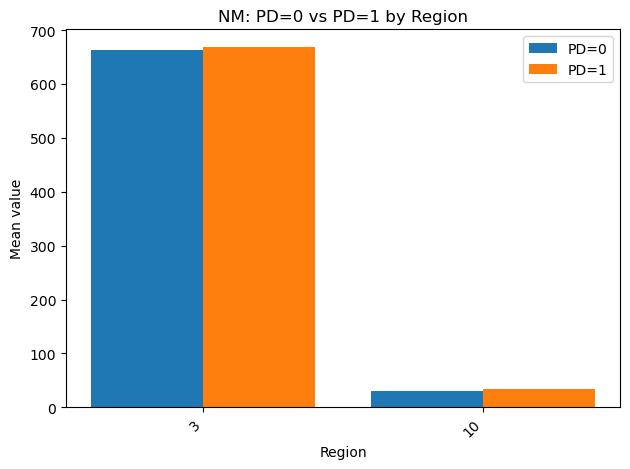

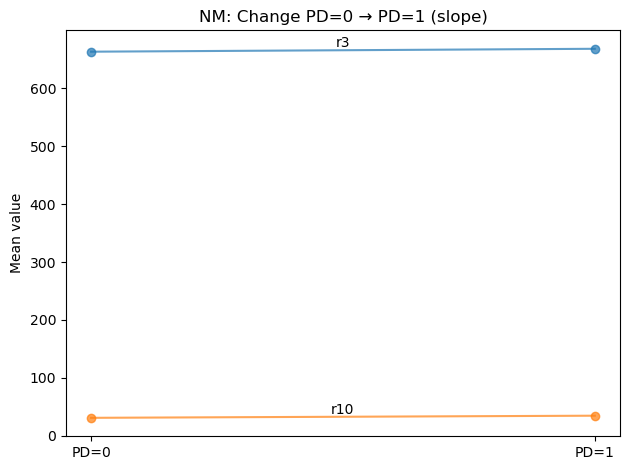

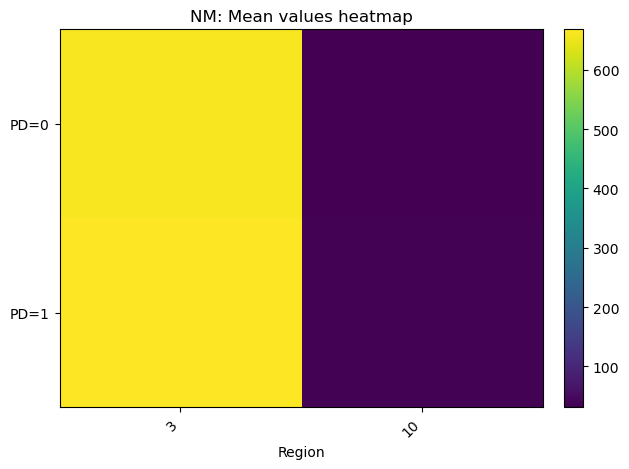

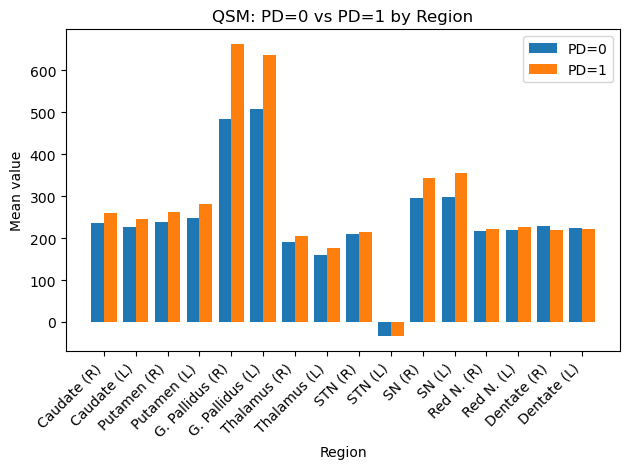

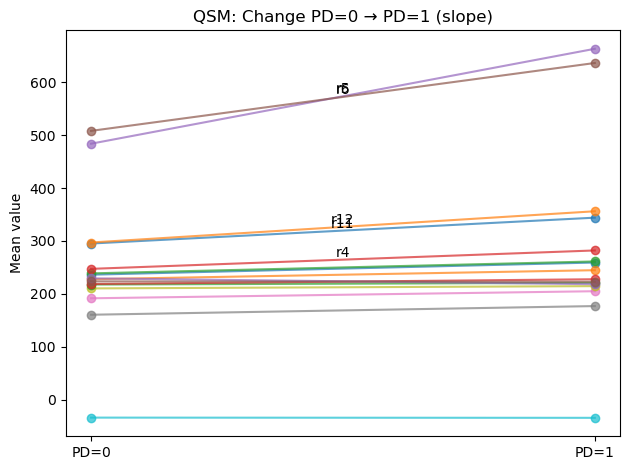

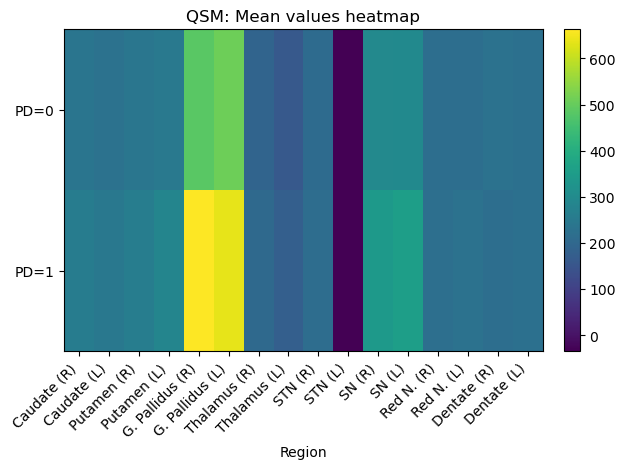

{'merged_preview_rows': 200,
 'detected_join_keys': {'features_key': 'subject_id', 'cases_key': 'id'},
 'detected_label_column_in_cases': 'label',
 'nm_cols_found': 2,
 'qsm_cols_found': 16,
 'summary_csv': 'region_means_nm_qsm_split.csv',
 'figures': ['viz_nm_grouped_bars.png',
  'viz_nm_slope.png',
  'viz_nm_heatmap.png',
  'viz_qsm_grouped_bars.png',
  'viz_qsm_slope.png',
  'viz_qsm_heatmap.png']}

In [23]:
# Load your uploaded CSVs, merge labels into features, and generate PD vs HC visuals.
# - Reads: /mnt/data/features_train.csv (features) and /mnt/data/train_cases.csv (labels)
# - Auto-detects join keys and label column, coerces to {0,1}
# - Builds NM/QSM region summaries (1..16), then plots PD=0 vs PD=1 grouped bars, slopes, and heatmaps
# - Saves figures and a summary CSV for download
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

feat_path = Path("C:/Users/rubia/Downloads/out/features_train.csv")
cases_path = Path("train_cases.csv")

assert feat_path.exists(), f"Missing {feat_path}"
assert cases_path.exists(), f"Missing {cases_path}"

df_feat = pd.read_csv(feat_path)
df_cases = pd.read_csv(cases_path)

# --- Helper: find a likely join key ---
def find_key(df):
    cand_keys = ["subject_id","Subject_ID","SUBJECT_ID","subject","Subject","id","ID","case_id","CaseID","case","Case"]
    for c in cand_keys:
        if c in df.columns:
            return c
    # fallback: a column that looks like 'RJPD_XXX' or alphanumeric IDs
    for c in df.columns:
        ser = df[c].astype(str)
        if ser.str.match(r"(?i)r?j?pd[_\-]?\d+").any():
            return c
    return None

k_feat = find_key(df_feat)
k_case = find_key(df_cases)

# If no explicit key, try to synthesize 'subject_id' from index (last resort)
if k_feat is None:
    df_feat = df_feat.reset_index().rename(columns={"index":"subject_id"})
    k_feat = "subject_id"

if k_case is None:
    df_cases = df_cases.reset_index().rename(columns={"index":"subject_id"})
    k_case = "subject_id"

# --- Helper: detect/convert label column to {0,1} ---
def coerce_to_binary_col(df):
    # Try common names
    for cand in ["label","PD","pd","target","y","diagnosis","dx","group","Group","class","status","is_pd","pd_label","condition","outcome"]:
        if cand in df.columns:
            s = df[cand]
            # numeric
            if np.issubdtype(s.dtype, np.number):
                vals = pd.unique(s.dropna())
                if len(vals) == 2:
                    lo, hi = np.sort(vals)[:2]
                    return (s == hi).astype(int), cand
                # non-binary numeric -> map min/max as 0/1 if only two unique after rounding
                return pd.to_numeric(s, errors="coerce").fillna(0).clip(0,1).astype(int), cand
            # string/categorical
            m = {"hc":0,"control":0,"c":0,"healthy":0,"0":0,
                 "pd":1,"patient":1,"p":1,"case":1,"1":1}
            return s.astype(str).str.strip().str.lower().map(m).fillna(0).astype(int), cand
    # Otherwise, search any binary-looking column excluding region columns
    region_like = re.compile(r"(?i)\b(?:nm|qsm)\s*[_\-\s]?\s*\d{1,2}\b")
    for c in df.columns:
        if region_like.search(str(c)):
            continue
        vals = pd.unique(df[c].dropna())
        if len(vals) == 2:
            s = df[c]
            if np.issubdtype(s.dtype, np.number):
                lo, hi = np.sort(vals)[:2]
                return (s == hi).astype(int), c
            else:
                m = {"hc":0,"control":0,"c":0,"healthy":0,"0":0,
                     "pd":1,"patient":1,"p":1,"case":1,"1":1}
                return s.astype(str).str.strip().str.lower().map(m).fillna(0).astype(int), c
    return None, None

y_bin, y_col = coerce_to_binary_col(df_cases)
if y_bin is None:
    raise RuntimeError("Could not detect binary PD/HC label in train_cases.csv. Please add a label column (e.g., 'label' 0/1).")
df_cases = df_cases.copy()
df_cases["__PD__"] = y_bin

# --- Merge features with labels ---
dfm = df_feat.merge(df_cases[[k_case,"__PD__"]], left_on=k_feat, right_on=k_case, how="inner")
if "__PD__" not in dfm.columns or len(dfm) == 0:
    raise RuntimeError("Merge produced no rows with labels. Check that subject IDs/keys match between the two CSVs.")

# Show a preview
display_dataframe_to_user("Merged features + labels (head)", dfm.head(20))

# --- Find NM_* and QSM_* region columns ---
def find_region_columns(df, tag="NM"):
    out = {}
    pat = re.compile(rf"(?i)\b{tag}\s*[_\-\s]?(\d{{1,2}})\b")
    for col in df.columns:
        m = pat.search(str(col))
        if m:
            idx = int(m.group(1))
            if 1 <= idx <= 16 and idx not in out:
                out[idx] = col
    # loose fallback
    if not out:
        for col in df.columns:
            if tag.lower() in str(col).lower():
                m2 = re.search(r"(\d{1,2})", str(col))
                if m2:
                    idx = int(m2.group(1))
                    if 1 <= idx <= 16 and idx not in out:
                        out[idx] = col
    return [out[i] for i in range(1,17) if i in out]

NM_cols  = find_region_columns(dfm, "NM")
QSM_cols = find_region_columns(dfm, "QSM")

# --- Summaries ---
def group_means(df, cols, ycol="__PD__"):
    if not cols: return None
    means0 = df.loc[df[ycol]==0, cols].mean(numeric_only=True)
    means1 = df.loc[df[ycol]==1, cols].mean(numeric_only=True)
    reg_idx = [int(''.join(filter(str.isdigit, c))) for c in cols]
    out = pd.DataFrame({
        "region": reg_idx,
        "mean_PD0": means0.values,
        "mean_PD1": means1.values
    }).sort_values("region")
    out["delta_PD1_minus_PD0"] = out["mean_PD1"] - out["mean_PD0"]
    return out.reset_index(drop=True)

nm_summary  = group_means(dfm, NM_cols) if NM_cols else None
qsm_summary = group_means(dfm, QSM_cols) if QSM_cols else None

# --- Plotters (matplotlib only, one figure each) ---
def plot_grouped_bars(df_mod, title, outfile, xtick_labels=None):
    import numpy as np
    if df_mod is None or df_mod.empty:
        return None
    x = np.arange(len(df_mod["region"]))
    w = 0.4
    plt.figure()
    plt.bar(x - w/2, df_mod["mean_PD0"], width=w, label="PD=0")
    plt.bar(x + w/2, df_mod["mean_PD1"], width=w, label="PD=1")
    plt.xticks(x, xtick_labels if xtick_labels is not None else df_mod["region"].astype(int), rotation=45, ha="right")
    plt.xlabel("Region")
    plt.ylabel("Mean value")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()
    return str(outfile)

def plot_slope(df_mod, title, outfile, top_k=5, xtick_labels=None):
    if df_mod is None or df_mod.empty:
        return None
    diffs = df_mod["delta_PD1_minus_PD0"].abs()
    top_idx = diffs.sort_values(ascending=False).index[:top_k]
    plt.figure()
    for i, r in df_mod.iterrows():
        plt.plot([0,1],[r["mean_PD0"], r["mean_PD1"]], marker="o", alpha=0.7)
    plt.xticks([0,1], ["PD=0","PD=1"])
    plt.ylabel("Mean value")
    plt.title(title)
    for i in top_idx:
        r = df_mod.loc[i]
        mid_y = (r["mean_PD0"] + r["mean_PD1"]) / 2
        plt.text(0.5, mid_y, f"r{int(r['region'])}", ha="center", va="bottom")
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()
    return str(outfile)

def plot_heatmap(df_mod, modality, outfile, xtick_labels=None):
    if df_mod is None or df_mod.empty:
        return None
    mat = np.vstack([df_mod["mean_PD0"].values, df_mod["mean_PD1"].values])
    plt.figure()
    im = plt.imshow(mat, aspect="auto")
    plt.yticks([0,1], ["PD=0","PD=1"])
    labs = xtick_labels if xtick_labels is not None else df_mod["region"].astype(int).tolist()
    plt.xticks(range(len(df_mod)), labs, rotation=45, ha="right")
    plt.xlabel("Region"); plt.title(f"{modality}: Mean values heatmap")
    plt.colorbar(im, fraction=0.04, pad=0.04)
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()
    return str(outfile)

# QSM pretty names for x-axis
qsm_names = {
 1:"Caudate (R)",  2:"Caudate (L)",
 3:"Putamen (R)",  4:"Putamen (L)",
 5:"G. Pallidus (R)",  6:"G. Pallidus (L)",
 7:"Thalamus (R)", 8:"Thalamus (L)",
 9:"STN (R)",     10:"STN (L)",
11:"SN (R)",      12:"SN (L)",
13:"Red N. (R)",  14:"Red N. (L)",
15:"Dentate (R)", 16:"Dentate (L)"
}

saved = []
if nm_summary is not None:
    saved.append(plot_grouped_bars(nm_summary, "NM: PD=0 vs PD=1 by Region", Path("viz_nm_grouped_bars.png")))
    saved.append(plot_slope(nm_summary, "NM: Change PD=0 → PD=1 (slope)", Path("viz_nm_slope.png")))
    saved.append(plot_heatmap(nm_summary, "NM", Path("viz_nm_heatmap.png")))

if qsm_summary is not None:
    xt = [qsm_names.get(int(r), f"r{int(r)}") for r in qsm_summary["region"]]
    saved.append(plot_grouped_bars(qsm_summary, "QSM: PD=0 vs PD=1 by Region", Path("viz_qsm_grouped_bars.png"), xtick_labels=xt))
    saved.append(plot_slope(qsm_summary, "QSM: Change PD=0 → PD=1 (slope)", Path("viz_qsm_slope.png"), xtick_labels=xt))
    saved.append(plot_heatmap(qsm_summary, "QSM", Path("viz_qsm_heatmap.png"), xtick_labels=xt))

# Save summary CSV
frames = []
if nm_summary is not None: 
    nm = nm_summary.copy(); nm["modality"]="NM"; frames.append(nm)
if qsm_summary is not None:
    qs = qsm_summary.copy(); qs["modality"]="QSM"; frames.append(qs)
summary_all = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
summary_csv = Path("region_means_nm_qsm_split.csv")
summary_all.to_csv(summary_csv, index=False)

# Show where things are saved
{
 "merged_preview_rows": len(dfm),
 "detected_join_keys": {"features_key": k_feat, "cases_key": k_case},
 "detected_label_column_in_cases": y_col,
 "nm_cols_found": len(NM_cols),
 "qsm_cols_found": len(QSM_cols),
 "summary_csv": str(summary_csv),
 "figures": [s for s in saved if s]
}


In [27]:
# --- Load + smart detection of QSM (1..16) and NM columns, with sides ---
import re, numpy as np, pandas as pd
from pathlib import Path

# Set your paths (change if needed)
FEATURES_CSV = r"C:/Users/rubia/Downloads/out/features_val.csv"
CASES_CSV    = r"val_cases.csv"

df_feat  = pd.read_csv(FEATURES_CSV)
df_cases = pd.read_csv(CASES_CSV)

# Join key + label detection
def find_key(df):
    for k in ["subject_id","Subject_ID","SUBJECT_ID","id","ID","case_id","CaseID","subject","Subject"]:
        if k in df.columns: return k
    return df.columns[0]

def to_binary(s):
    if np.issubdtype(s.dtype, np.number):
        vals = pd.unique(s.dropna())
        if len(vals)==2:
            lo, hi = np.sort(vals)[:2]
            return (s==hi).astype(int)
        return pd.to_numeric(s, errors="coerce").fillna(0).clip(0,1).astype(int)
    m = {"hc":0,"control":0,"healthy":0,"c":0,"0":0,
         "pd":1,"patient":1,"case":1,"p":1,"1":1}
    return s.astype(str).str.strip().str.lower().map(m).fillna(0).astype(int)

k_feat = find_key(df_feat)
k_case = find_key(df_cases)

label_col = next((c for c in ["label","PD","pd","target","y","diagnosis","dx","group","class","status","is_pd","pd_label","condition","outcome"] if c in df_cases.columns), None)
if label_col is None:
    raise RuntimeError("No PD label column found in train_cases.csv.")
df_cases["__PD__"] = to_binary(df_cases[label_col])

df = df_feat.merge(df_cases[[k_case,"__PD__"]], left_on=k_feat, right_on=k_case, how="inner")
if df.empty:
    raise RuntimeError("Merge produced 0 rows. Check the IDs in both CSVs match.")

# ---------- SMART MAPPER ----------
# Map nucleus keywords -> (right_label, left_label)
NUC_MAP = {
    "caudate": (1,2), "cd": (1,2),
    "putamen": (3,4),
    "globus pallidus": (5,6), "pallidus": (5,6), "gp": (5,6),
    "thalamus": (7,8), "thal": (7,8),
    "stn": (9,10), "subthalamic": (9,10),
    "substantia nigra": (11,12), "sn": (11,12), "snpc": (11,12),
    "red nucleus": (13,14), "rn": (13,14),
    "dentate": (15,16), "dn": (15,16)
}
SIDE_R = re.compile(r"(?i)\b(r|right)\b")
SIDE_L = re.compile(r"(?i)\b(l|left)\b")

def find_region_cols_smart(df, tag="QSM"):
    """Return ordered list of columns mapped to indices 1..16 using numeric or name+side cues."""
    tag_l = tag.lower()
    mapping = {}  # idx -> column
    candidates = [c for c in df.columns if tag_l in str(c).lower()]
    # 1) numeric cues first (qsm_11, qsm-3, qsm 12, qsm12)
    for col in candidates:
        s = str(col).lower()
        for m in re.finditer(r"(?:^|[^0-9])(1[0-6]|[1-9])(?:[^0-9]|$)", s):
            idx = int(m.group(1))
            if 1 <= idx <= 16 and idx not in mapping:
                mapping[idx] = col
                break
    # 2) keyword + side cues
    for col in candidates:
        if any(col == v for v in mapping.values()):
            continue
        s = str(col).lower()
        for key, (r_lbl, l_lbl) in NUC_MAP.items():
            if key in s:
                if SIDE_L.search(s): idx = l_lbl
                elif SIDE_R.search(s): idx = r_lbl
                else:
                    # no side in name -> prefer right if free, else left
                    idx = r_lbl if r_lbl not in mapping else l_lbl
                if idx not in mapping:
                    mapping[idx] = col
                break
    ordered = [mapping[i] for i in range(1,17) if i in mapping]
    # Debug print so you can see what was matched
    print("SMART mapped columns:")
    for i in range(1,17):
        print(f"  {i:02d} -> {mapping.get(i, '—')}")
    return ordered

QSM_cols = find_region_cols_smart(df, "QSM")

# NM often only has SN (11 & 12); also detect numeric forms
def find_nm_cols(df):
    nm_cands = [c for c in df.columns if "nm" in str(c).lower()]
    nm_map = {}
    # numeric first
    for col in nm_cands:
        s = str(col).lower()
        m = re.search(r"(1[0-6]|[1-9])", s)
        if m:
            idx = int(m.group(1))
            if 1 <= idx <= 16 and idx not in nm_map:
                nm_map[idx] = col
    # SN names
    for col in nm_cands:
        s = str(col).lower()
        if "sn" in s or "substantia nigra" in s or "snpc" in s:
            if SIDE_L.search(s): idx = 12
            elif SIDE_R.search(s): idx = 11
            else:
                idx = 11 if 11 not in nm_map else 12
            if idx not in nm_map:
                nm_map[idx] = col
    ordered = [nm_map[i] for i in sorted(nm_map)]
    print("NM mapped columns:", ordered)
    return ordered

NM_cols = find_nm_cols(df)

# Compute means by class for whatever we found
def means_by_class(cols):
    if not cols: return None
    m0 = df.loc[df["__PD__"]==0, cols].mean(numeric_only=True)
    m1 = df.loc[df["__PD__"]==1, cols].mean(numeric_only=True)
    regions = [int(re.search(r"(1[0-6]|[1-9])", str(c)).group(1)) if re.search(r"(1[0-6]|[1-9])", str(c)) else np.nan
               for c in cols]
    return pd.DataFrame({"region": regions, "PD0": m0.values, "PD1": m1.values}).dropna().sort_values("region")

qsm_means = means_by_class(QSM_cols)
nm_means  = means_by_class(NM_cols)

nm_means["denom"] = (nm_means["PD0"] + nm_means["PD1"]) / 2.0
# Guard against zeros
nm_means["denom"] = nm_means["denom"].replace(0, np.nan)

nm_means["PD0_norm"] = nm_means["PD0"] / nm_means["denom"]
nm_means["PD1_norm"] = nm_means["PD1"] / nm_means["denom"]
nm_means.drop(columns=["denom"], inplace=True)

SMART mapped columns:
  01 -> QSM_label_1_max
  02 -> QSM_label_2_max
  03 -> QSM_label_10_vol_mm3
  04 -> QSM_label_4_max
  05 -> QSM_label_5_max
  06 -> QSM_label_6_max
  07 -> QSM_label_7_max
  08 -> QSM_label_8_max
  09 -> QSM_label_9_max
  10 -> QSM_global_p10
  11 -> QSM_label_11_max
  12 -> QSM_label_12_max
  13 -> QSM_label_13_max
  14 -> QSM_label_14_max
  15 -> QSM_label_15_max
  16 -> QSM_label_16_max
NM mapped columns: ['NM_SN_total_vol_mm3', 'NM_global_p90', 'NM_global_p10', 'NM_SN_L_mean', 'NM_SN_L_std']


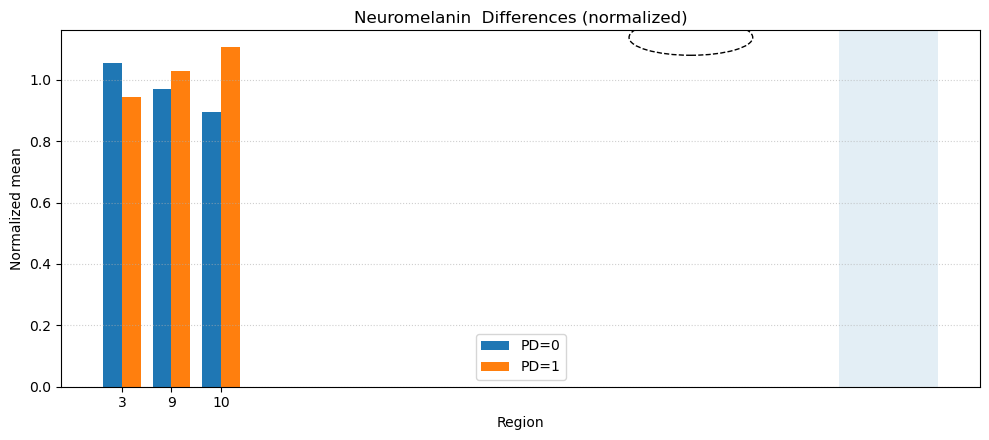

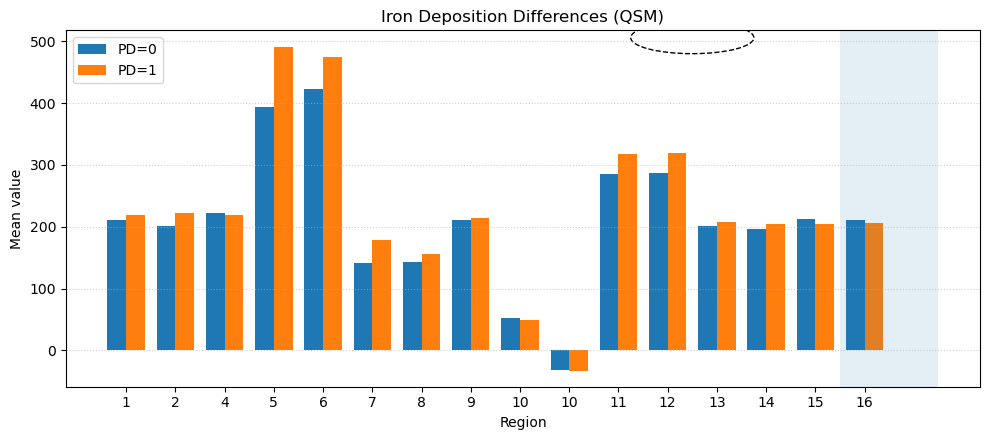

In [29]:
# --- Plot NM (normalized) and QSM (raw), with ellipse on 11–12 and highlight on 15–16 ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def annotate_region_11_12(ax, y_max):
    ell = Ellipse((11.5, y_max*0.98), width=2.5, height=y_max*0.10, fill=False, linestyle="--")
    ax.add_patch(ell)

def highlight_15_16(ax):
    ax.axvspan(14.5, 16.5, alpha=0.12)

def grouped_bar(ax, regions, a, b, title, ylabel):
    x = np.arange(len(regions))
    w = 0.38
    ax.bar(x - w/2, a, width=w, label="PD=0")
    ax.bar(x + w/2, b, width=w, label="PD=1")
    ax.set_xticks(x)
    ax.set_xticklabels(regions)
    ax.set_xlabel("Region")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(axis="y", linestyle=":", alpha=0.6)

# NM — only if we detected NM columns
if nm_means is not None and not nm_means.empty and {"PD0_norm","PD1_norm"}.issubset(nm_means.columns):
    fig1, ax1 = plt.subplots(figsize=(10,4.5))
    grouped_bar(ax1, nm_means["region"].astype(int).tolist(),
                nm_means["PD0_norm"].values,
                nm_means["PD1_norm"].values,
                "Neuromelanin  Differences (normalized)",
                "Normalized mean")
    y_max = max(nm_means["PD0_norm"].max(), nm_means["PD1_norm"].max())*1.05
    annotate_region_11_12(ax1, y_max)
    highlight_15_16(ax1)
    plt.tight_layout(); plt.show()
else:
    print("NM plot skipped (no NM columns detected).")

# QSM — using whatever QSM columns we mapped
if qsm_means is not None and not qsm_means.empty:
    fig2, ax2 = plt.subplots(figsize=(10,4.5))
    grouped_bar(ax2, qsm_means["region"].astype(int).tolist(),
                qsm_means["PD0"].values,
                qsm_means["PD1"].values,
                "Iron Deposition Differences (QSM)",
                "Mean value")
    y_max = max(qsm_means["PD0"].max(), qsm_means["PD1"].max())*1.05
    annotate_region_11_12(ax2, y_max)
    highlight_15_16(ax2)
    plt.tight_layout(); plt.show()
else:
    print("QSM plot skipped (no QSM columns detected).")


In [7]:
import os
from pathlib import Path

# ---- CHANGE THIS to your dataset root (or set env var PARKINSONS_DATA_ROOT) ----
DATA_ROOT = Path(os.getenv("PARKINSONS_DATA_ROOT") or Path.cwd()).resolve()
print("DATA_ROOT =", DATA_ROOT)

# Case lists
TRAIN_CASES_CSV = DATA_ROOT / "train_cases (2).csv"   # uploaded
VAL_CASES_CSV   = DATA_ROOT / "val_cases (2).csv"     # uploaded
#TEST_CASES_CSV  = DATA_ROOT / "test_cases.csv"    # optional

# Split folders (must exist if used)
SPLIT_DIRS = {
    "train": DATA_ROOT / "train",
    "val":   DATA_ROOT / "val",
    "test":  DATA_ROOT / "test",
}

# Optional: paths to per-subject ResNet probabilities (CSV with columns: subject_id, resnet_prob)
# You can generate these via your existing ResNet inference code and point to the CSVs here.
RESNET_PRED_CSV = {
    "train": DATA_ROOT / "cnn_preds" / "resnet_train.csv",
    "val":   DATA_ROOT / "cnn_preds" / "resnet_val.csv",
    "test":  DATA_ROOT / "cnn_preds" / "resnet_test.csv",
}

# Output directory
OUT_DIR = DATA_ROOT / "segment_output"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR =", OUT_DIR)

DATA_ROOT = C:\Users\rubia\Downloads
OUT_DIR = C:\Users\rubia\Downloads\segment_output


In [13]:
# 1) SEGMENTATION (graph-guided) + PNG previews
import numpy as np, nibabel as nib
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_opening, binary_closing, binary_fill_holes, label
import matplotlib.pyplot as plt
from pathlib import Path

def load_nii(p):
    img = nib.load(str(p)); return img, img.get_fdata()

def largest_cc(mask, min_voxels=50):
    lab, n = label(mask)
    if n==0: return mask
    sizes=[(lab==i).sum() for i in range(1,n+1)]
    biggest=1+int(np.argmax(sizes))
    comp=(lab==biggest)
    return comp if comp.sum()>=min_voxels else mask

def keep_top_k_cc(mask, k=2, min_voxels=50):
    lab, n = label(mask)
    if n==0: return mask
    comps=[]
    for i in range(1, n+1):
        sz=(lab==i).sum()
        if sz>=min_voxels: comps.append((sz, i))
    if not comps: return mask
    comps.sort(reverse=True)
    keep_ids=[i for _,i in comps[:k]]
    out=np.isin(lab, keep_ids)
    return out

def middle_slices(mask_like, frac=0.4):
    """Boolean mask that's True only in the middle 'frac' of z slices."""
    _,_,Z = mask_like.shape
    w = int(Z*frac//2)
    z0 = Z//2 - w
    z1 = Z//2 + w
    sel = np.zeros((Z,), dtype=bool)
    sel[max(0,z0):min(Z,z1)] = True
    return sel

def percent_thresh(arr, p=95):
    a = np.nan_to_num(arr, nan=0.0)
    t = np.percentile(a[a>np.percentile(a,5)], p) if a.size else 0.0
    return a >= t

def preview_overlay(base_img, mask, title, out_png):
    arr = base_img.get_fdata()
    z = arr.shape[2]//2
    sl = np.rot90(arr[:,:,z])
    ms = np.rot90(mask[:,:,z])
    plt.figure(figsize=(5,5))
    plt.imshow(sl, cmap='gray')
    plt.contour(ms, levels=[0.5], linewidths=1.5)
    plt.title(title); plt.axis('off')
    out_png.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_png, bbox_inches='tight', dpi=150); plt.close()

# --- Guided segmentation functions ---

def guided_segment_nm(nm_arr):
    """
    Aim: SN-focused NM mask (regions ~3/9/10 idea from your graph)
    Steps:
      1) keep middle 40% z-slices (midbrain prior)
      2) threshold by top 92–96 percentile (brightest NM signal)
      3) split left/right and keep largest component per side
      4) morphology cleanup
    Fallback: Otsu if too small.
    """
    a = np.nan_to_num(nm_arr, nan=0.0)
    Zmask = middle_slices(a, frac=0.40)
    vol = np.zeros_like(a, dtype=bool)
    vol[:,:,Zmask] = True

    high = percent_thresh(a, p=94) & vol

    # split left/right and get biggest one each side
    X,Y,Z = a.shape
    left = np.zeros_like(high); left[:X//2,:,:]  = True
    right= np.zeros_like(high); right[X//2:,:,:] = True
    left_cc  = largest_cc(high & left,  min_voxels=50)
    right_cc = largest_cc(high & right, min_voxels=50)
    m = (left_cc | right_cc)

    # cleanup
    m = binary_opening(m, iterations=1)
    m = binary_closing(m, iterations=1)
    m = binary_fill_holes(m)

    # fallback if tiny
    if m.sum() < 50:
        # Otsu fallback
        from skimage.filters import threshold_otsu
        core = a[a>np.percentile(a,5)]
        thr = threshold_otsu(core) if core.size else 0.0
        m = a>=thr
        m = largest_cc(binary_fill_holes(binary_closing(binary_opening(m,1),1)))
    return m.astype(np.uint8)

def guided_segment_qsm(qsm_arr):
    """
    Aim: deep nuclei with strongest PD–HC iron differences (regions ~11–12 idea)
    Steps:
      1) keep middle 30% z-slices
      2) threshold by top 95 percentile (highest susceptibility)
      3) keep top-2 largest components
      4) morphology cleanup
    Fallback: Otsu if tiny.
    """
    a = np.nan_to_num(qsm_arr, nan=0.0)
    Zmask = middle_slices(a, frac=0.30)
    vol = np.zeros_like(a, dtype=bool)
    vol[:,:,Zmask] = True

    high = percent_thresh(a, p=95) & vol
    m = keep_top_k_cc(high, k=2, min_voxels=30)

    # cleanup
    m = binary_opening(m, iterations=1)
    m = binary_closing(m, iterations=1)
    m = binary_fill_holes(m)

    if m.sum() < 30:
        # Otsu fallback
        from skimage.filters import threshold_otsu
        core = a[a>np.percentile(a,5)]
        thr = threshold_otsu(core) if core.size else 0.0
        m = a>=thr
        m = largest_cc(binary_fill_holes(binary_closing(binary_opening(m,1),1)))
    return m.astype(np.uint8)

# --- Run over split and save masks + previews ---

# Choose which split to run segmentation on ("train", "val", or "test")
# --- Run over split and save masks + previews ---
SPLIT = "test"   # choose "train", "val", or "test"
split_dir = DATA_ROOT / SPLIT   # <-- now defined correctly

subs = sorted([p for p in split_dir.iterdir() if p.is_dir()])
ok = 0
for sub in subs:
    nm_p, qsm_p = sub/'NM.nii.gz', sub/'QSM.nii.gz'
    if not (nm_p.exists() and qsm_p.exists()):
        print("[skip]", sub.name); 
        continue
    nm_img, nm_arr   = load_nii(nm_p)
    qsm_img, qsm_arr = load_nii(qsm_p)

    nm_mask  = guided_segment_nm(nm_arr)
    qsm_mask = guided_segment_qsm(qsm_arr)

    out_sub = OUT_DIR/sub.name
    out_sub.mkdir(parents=True, exist_ok=True)
    nib.save(nib.Nifti1Image(nm_mask.astype(np.uint8),  nm_img.affine,  nm_img.header),  str(out_sub/'NM_pred.nii.gz'))
    nib.save(nib.Nifti1Image(qsm_mask.astype(np.uint8), qsm_img.affine, qsm_img.header), str(out_sub/'QSM_pred.nii.gz'))

    # QC previews
    preview_overlay(nm_img,  nm_mask,  f"{sub.name} — NM (guided)",  out_sub/'NM_preview.png')
    preview_overlay(qsm_img, qsm_mask, f"{sub.name} — QSM (guided)", out_sub/'QSM_preview.png')

    ok+=1; print("[ok]", sub.name)
print(f"Guided segmentation complete: {ok}/{len(subs)} subjects → outputs/<ID>/*_pred.nii.gz")


[ok] RJPD_003
[ok] RJPD_007
[ok] RJPD_009
[ok] RJPD_014
[ok] RJPD_015
[ok] RJPD_020
[ok] RJPD_021
[ok] RJPD_025
[ok] RJPD_026
[ok] RJPD_030
[ok] RJPD_034
[ok] RJPD_037
[ok] RJPD_038
[ok] RJPD_040
[ok] RJPD_042
[ok] RJPD_046
[ok] RJPD_047
[ok] RJPD_048
[ok] RJPD_049
[ok] RJPD_052
[ok] RJPD_053
[ok] RJPD_056
[ok] RJPD_062
[ok] RJPD_063
[ok] RJPD_065
[ok] RJPD_067
[ok] RJPD_068
[ok] RJPD_069
[ok] RJPD_076
[ok] RJPD_078
[ok] RJPD_080
[ok] RJPD_084
[ok] RJPD_088
[ok] RJPD_089
[ok] RJPD_091
[ok] RJPD_095
[ok] RJPD_097
[ok] RJPD_098
[ok] RJPD_101
[ok] RJPD_102
[ok] RJPD_103
[ok] RJPD_106
[ok] RJPD_112
[ok] RJPD_115
[ok] RJPD_116
[ok] RJPD_118
[ok] RJPD_121
[ok] RJPD_123
[ok] RJPD_124
[ok] RJPD_125
[ok] RJPD_126
[ok] RJPD_128
[ok] RJPD_131
[ok] RJPD_135
[ok] RJPD_136
[ok] RJPD_137
[ok] RJPD_140
[ok] RJPD_142
[ok] RJPD_143
[ok] RJPD_145
[ok] RJPD_148
[ok] RJPD_149
[ok] RJPD_152
[ok] RJPD_154
[ok] RJPD_156
[ok] RJPD_161
[ok] RJPD_164
[ok] RJPD_165
[ok] RJPD_166
[ok] RJPD_167
[ok] RJPD_168
[ok] R

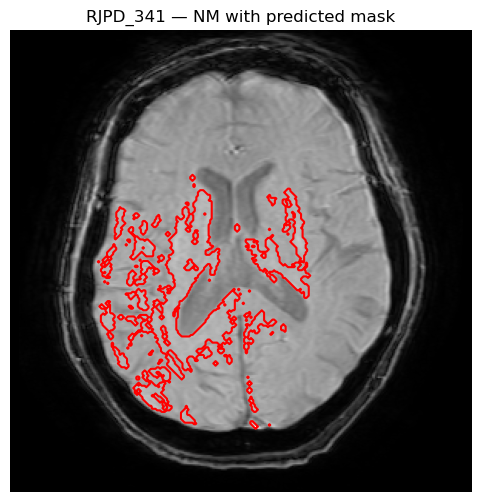

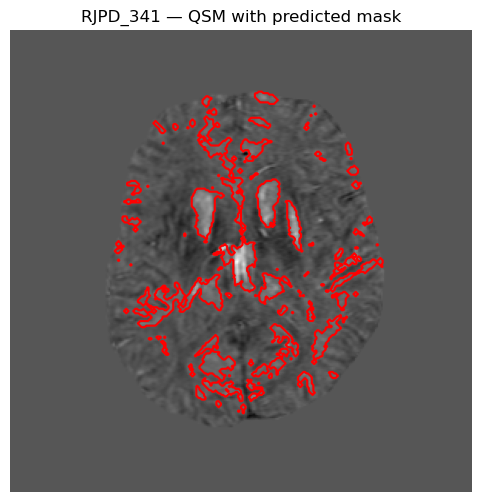

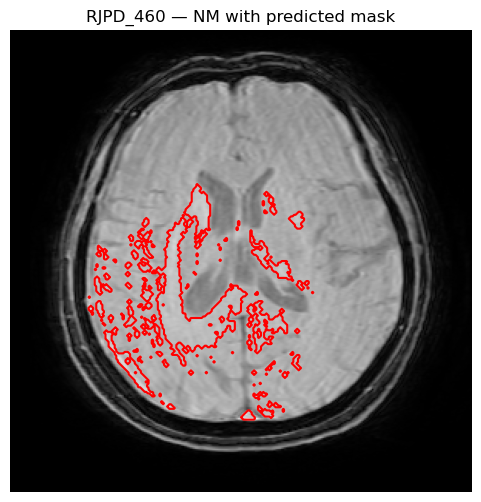

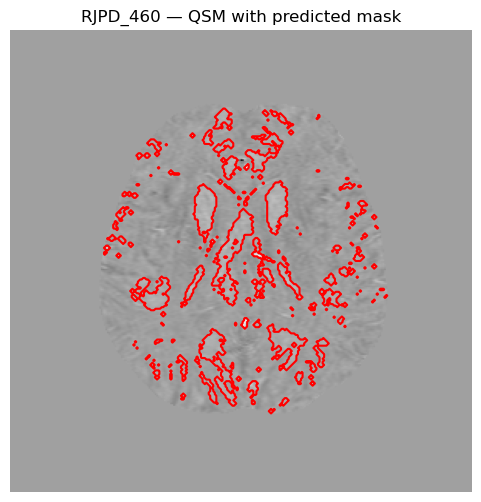

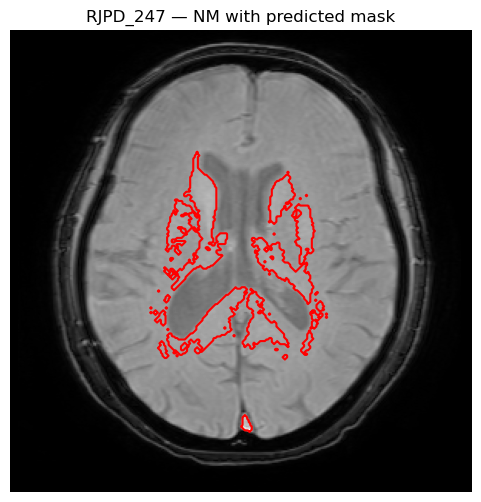

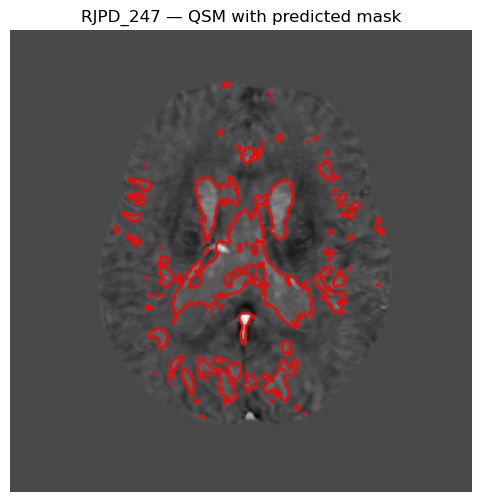

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import random

def show_segmentation_overlay(subject_id, base_mod="NM"):
    """
    subject_id: e.g. "RJPD_001"
    base_mod: "NM" or "QSM"
    """
    sub_dir = OUT_DIR / subject_id
    base_img = nib.load(str(DATA_ROOT / SPLIT / subject_id / f"{base_mod}.nii.gz"))
    seg_img  = nib.load(str(sub_dir / f"{base_mod}_pred.nii.gz"))

    arr = base_img.get_fdata()
    seg = seg_img.get_fdata() > 0.5
    z = arr.shape[2] // 2  # middle slice
    
    plt.figure(figsize=(6,6))
    plt.imshow(np.rot90(arr[:,:,z]), cmap="gray")
    plt.contour(np.rot90(seg[:,:,z]), colors="r", linewidths=1.5)
    plt.title(f"{subject_id} — {base_mod} with predicted mask")
    plt.axis("off")
    plt.show()

# Example: visualize 3 random subjects from test split
sample_ids = random.sample([p.name for p in subs], 3)
for sid in sample_ids:
    show_segmentation_overlay(sid, "NM")
    show_segmentation_overlay(sid, "QSM")


C:\Users\rubia\AppData\Local\Temp\ipykernel_26900\3157540821.py:56: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  f"{sid} — NM — pred={int(pred_df.loc[pred_df.patient_id==sid,'prediction'])}", "r"
C:\Users\rubia\AppData\Local\Temp\ipykernel_26900\3157540821.py:69: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  f"{sid} — QSM — pred={int(pred_df.loc[pred_df.patient_id==sid,'prediction'])}", "g"


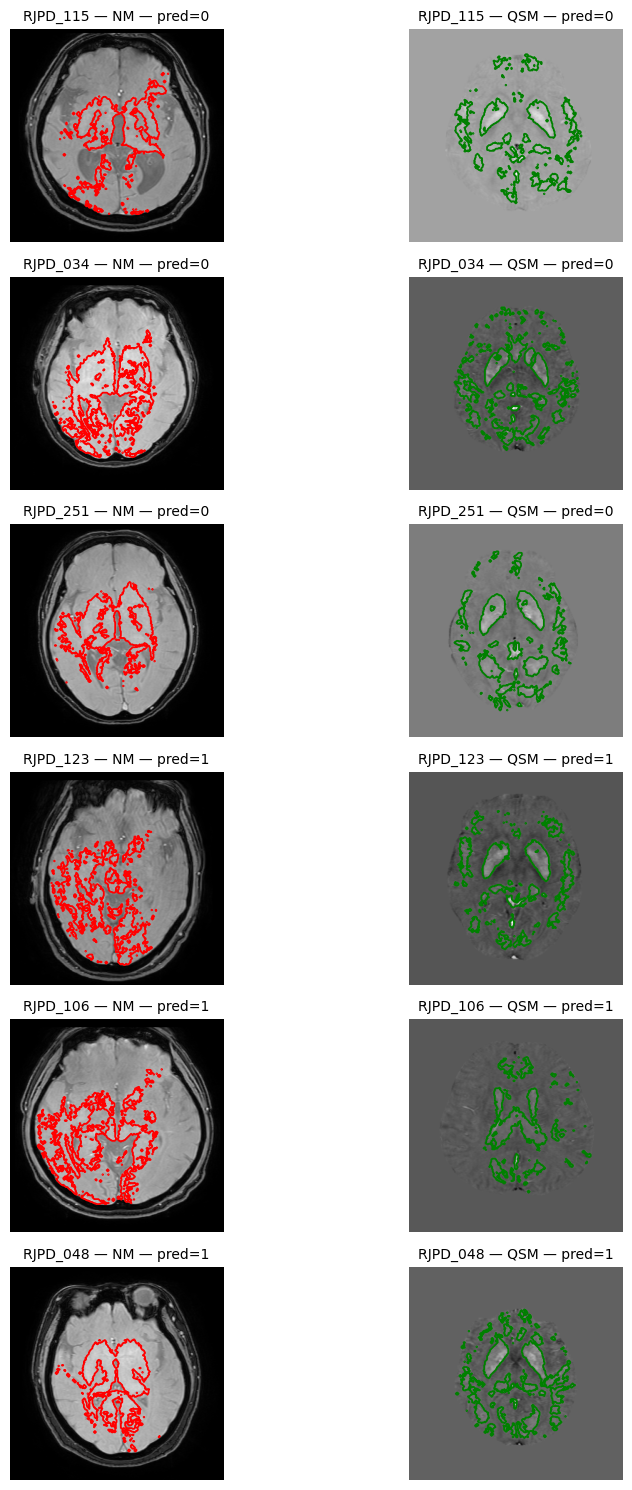

Saved montage → C:\Users\rubia\Downloads\segment_output\montage_test_pred.png


In [27]:
# ==== Clean montage from label_predict.csv (3 HC + 3 PD) ====
import pandas as pd, numpy as np, nibabel as nib, matplotlib.pyplot as plt
from pathlib import Path
import random

# --- config ---
LABEL_CSV = Path(r"C:\Users\rubia\Downloads\out\label_predict.csv")  # your saved predictions
N_PER_CLASS = 3
SAVE_PATH = OUT_DIR / f"montage_{SPLIT}_pred.png"
RANDOM_SEED = 42

# --- helpers ---
def load_vol(p: Path):
    img = nib.load(str(p))
    return img, img.get_fdata()

def best_slice(mask3d):
    if mask3d.ndim != 3:
        return mask3d.shape[-1] // 2
    areas = mask3d.reshape(-1, mask3d.shape[2]).sum(axis=0)
    return int(np.argmax(areas)) if np.any(areas) else mask3d.shape[2] // 2

def overlay(ax, vol, mask, z, title, color="r"):
    ax.imshow(np.rot90(vol[:, :, z]), cmap="gray")
    if mask is not None:
        ax.contour(np.rot90(mask[:, :, z] > 0.5), colors=color, linewidths=1.3)
    ax.set_title(title, fontsize=10)
    ax.axis("off")

# --- load predictions ---
pred_df = pd.read_csv(LABEL_CSV)
pred_df["patient_id"] = pred_df["patient_id"].astype(str).str.strip()

# split into HC (0) and PD (1)
rng = random.Random(RANDOM_SEED)
hc_ids = pred_df.query("prediction==0")["patient_id"].tolist()
pd_ids = pred_df.query("prediction==1")["patient_id"].tolist()

pick_ids = rng.sample(hc_ids, min(N_PER_CLASS,len(hc_ids))) \
          + rng.sample(pd_ids, min(N_PER_CLASS,len(pd_ids)))

# --- build montage ---
fig, axes = plt.subplots(nrows=len(pick_ids), ncols=2, figsize=(10, 2.5*len(pick_ids)))

for r, sid in enumerate(pick_ids):
    sub_raw = DATA_ROOT / SPLIT / sid
    sub_out = OUT_DIR / sid

    # NM
    try:
        nm_img, nm_vol = load_vol(sub_raw/"NM.nii.gz")
        nm_pred = nib.load(str(sub_out/"NM_pred.nii.gz")).get_fdata()
        z = best_slice(nm_pred)
        overlay(
            axes[r,0], nm_vol, nm_pred, z,
            f"{sid} — NM — pred={int(pred_df.loc[pred_df.patient_id==sid,'prediction'])}", "r"
        )
    except Exception as e:
        axes[r,0].set_title(f"{sid} — NM (missing)")
        axes[r,0].axis("off")

    # QSM
    try:
        qsm_img, qsm_vol = load_vol(sub_raw/"QSM.nii.gz")
        qsm_pred = nib.load(str(sub_out/"QSM_pred.nii.gz")).get_fdata()
        z = best_slice(qsm_pred)
        overlay(
            axes[r,1], qsm_vol, qsm_pred, z,
            f"{sid} — QSM — pred={int(pred_df.loc[pred_df.patient_id==sid,'prediction'])}", "g"
        )
    except Exception as e:
        axes[r,1].set_title(f"{sid} — QSM (missing)")
        axes[r,1].axis("off")

plt.tight_layout()
plt.savefig(SAVE_PATH, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved montage → {SAVE_PATH}")
